In [ ]:
-%pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.5 MB/s eta 0:00:00


In [ ]:
import random
import operator

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [ ]:
# Preprocessing train data

titanicDatasetFilePath = "/content/train.csv"
titanicData = pd.read_csv(titanicDatasetFilePath, index_col='PassengerId')
features = ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
X = titanicData[features]

na_counts = X.isna().sum()
print("NA Values before preprocessing: ", na_counts)

X = X.dropna(subset=["Embarked"])
medianAge = X['Age'].median()
X['Age'].fillna(medianAge, inplace=True)

na_counts = X.isna().sum()
print("NA Values before preprocessing: ", na_counts)

y = X.Survived
X = X[features[1:]]

X = pd.get_dummies(X, columns=['Sex'])
X = pd.get_dummies(X, columns=['Embarked'])


train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

X.head()

NA Values before preprocessing:  Survived      0
Pclass        0
Sex           0
Age         177
Fare          0
Embarked      2
dtype: int64
NA Values before preprocessing:  Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
dtype: int64


,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
1,3,22.0,7.2500,0,1,0,0,1
2,1,38.0,71.2833,1,0,1,0,0
3,3,26.0,7.9250,1,0,0,0,1
4,1,35.0,53.1000,1,0,0,0,1
5,3,35.0,8.0500,0,1,0,0,1


In [ ]:
# preprocessing test data
titanicDatasetFilePathTest = "/content/test.csv"
titanicDataTest = pd.read_csv(titanicDatasetFilePathTest, index_col='PassengerId')
titanicDataTest.head()
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
X_validation = titanicDataTest[features]

na_counts = X_validation.isna().sum()
print("NA Values before preprocessing: ", na_counts)
X_validation = X_validation.dropna(subset=["Embarked"])

medianAge = X_validation['Age'].median()
X_validation['Age'].fillna(medianAge, inplace=True)
medianFare = X['Fare'].median()
X_validation['Fare'].fillna(medianAge, inplace=True)

na_counts = X_validation.isna().sum()
print("NA Values after preprocessing: ", na_counts)

X_validation = pd.get_dummies(X_validation, columns=['Sex'])
X_validation = pd.get_dummies(X_validation, columns=['Embarked'])
X_validation.head()

NA Values before preprocessing:  Pclass       0
Sex          0
Age         86
Fare         1
Embarked     0
dtype: int64
NA Values after preprocessing:  Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
dtype: int64


,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
892,3,34.5,7.8292,0,1,0,1,0
893,3,47.0,7.0000,1,0,0,0,1
894,2,62.0,9.6875,0,1,0,1,0
895,3,27.0,8.6625,0,1,0,0,1
896,3,22.0,12.2875,1,0,0,0,1


In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
pset = gp.PrimitiveSetTyped("MAIN", [float] * 8, bool)

# mathematical operations
pset.addPrimitive(operator.add, in_types = [float, float], ret_type=float)
pset.addPrimitive(operator.sub, in_types = [float, float], ret_type=float)
pset.addPrimitive(operator.mul, in_types = [float, float], ret_type=float)
pset.addPrimitive(operator.neg, in_types = [float], ret_type=float)

# boolean operators
pset.addPrimitive(operator.gt, in_types = [float, float], ret_type=bool)
pset.addPrimitive(operator.le, in_types = [float, float], ret_type=bool)
pset.addPrimitive(operator.eq, in_types = [float, float], ret_type=bool)


pset.renameArguments(ARG0='Pclass', ARG1='Age', 	ARG2='Fare', 	ARG3='Sex_female',
                     ARG4='Sex_male',  ARG5='Embarked_C', 	ARG6='Embarked_Q',
                     ARG7='Embarked_S')



In [ ]:
# evaluation function
def evalFPFN(indiv, X_test, y_test, pset):
  y_pred = []
  func = gp.compile(expr=indiv, pset=pset)

  for row in X_test.to_numpy():
    pred = func(*row)
    y_pred.append(1 if pred else 0)

  # print(y_pred)

  y_pred = np.array(y_pred)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  fpr = fp/(fp + tn)
  fnr = fn/(fn + tp)

  return (fpr, fnr)

In [ ]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalFPFN, pset=pset)
toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_ = 0, max_ = 2)
toolbox.register("mutate", gp.mutNodeReplacement, pset = pset)

In [ ]:
  # genetic loop
fnr_avg_list = []
fnr_min_list = []
fnr_max_list = []
fpr_avg_list = []
fpr_min_list = []
fpr_max_list = []

pop_size = 1000
generations = 100
mate_prob = 0.4
mutation_prob = 0.2

pop = toolbox.population(n=pop_size)
pareto_front=tools.ParetoFront()

fitnesses = [toolbox.evaluate(ind, val_X, val_y) for ind in pop]
for ind, fit in zip(pop, fitnesses):
    print(fit)
    ind.fitness.values = fit

for generation in range(generations):

    print("-- Generation %i --" % (generation + 1))

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < mate_prob:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values


    for mutant in offspring:
        if random.random() < mutation_prob:
            # print(type(mutant))
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(ind, val_X, val_y) for ind in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pareto_front.update(offspring)

    pop[:] = offspring

fittness_obj1 = [ind.fitness.values[0] for ind in pareto_front]
fittness_obj2 = [ind.fitness.values[1] for ind in pareto_front]

fittness_obj1 = [fittness_obj1[0]] + fittness_obj1 + [1]
fittness_obj2 = [1] + fittness_obj2 + [fittness_obj2[-1]]


print(fittness_obj1)
print(fittness_obj2)

(0.34057971014492755, 0.16470588235294117)
(0.028985507246376812, 0.9882352941176471)
(0.028985507246376812, 0.7529411764705882)
(0.0, 1.0)
(0.2536231884057971, 0.5058823529411764)
(0.028985507246376812, 1.0)
(0.0, 1.0)
(1.0, 0.011764705882352941)
(0.6884057971014492, 0.5882352941176471)
(0.8260869565217391, 0.7058823529411765)
(1.0, 0.0)
(0.8985507246376812, 0.6941176470588235)
(0.18840579710144928, 0.23529411764705882)
(0.028985507246376812, 1.0)
(0.8333333333333334, 0.25882352941176473)
(1.0, 0.0)
(1.0, 0.0)
(0.014492753623188406, 0.9411764705882353)
(0.07246376811594203, 0.9882352941176471)
(1.0, 0.011764705882352941)
(0.0, 1.0)
(0.028985507246376812, 1.0)
(0.028985507246376812, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.9927536231884058, 0.0)
(0.9927536231884058, 0.011764705882352941)
(0.0, 1.0)
(0.0, 1.0)
(0.26811594202898553, 0.17647058823529413)
(0.3115942028985507, 0.4117647058823529)
(0.007246376811594203, 1.0)
(0.7463768115942029, 0.32941176470588235)
(0.028985507246376812, 0.98823529411

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007246376811594203, 0.007246376811594203, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885,

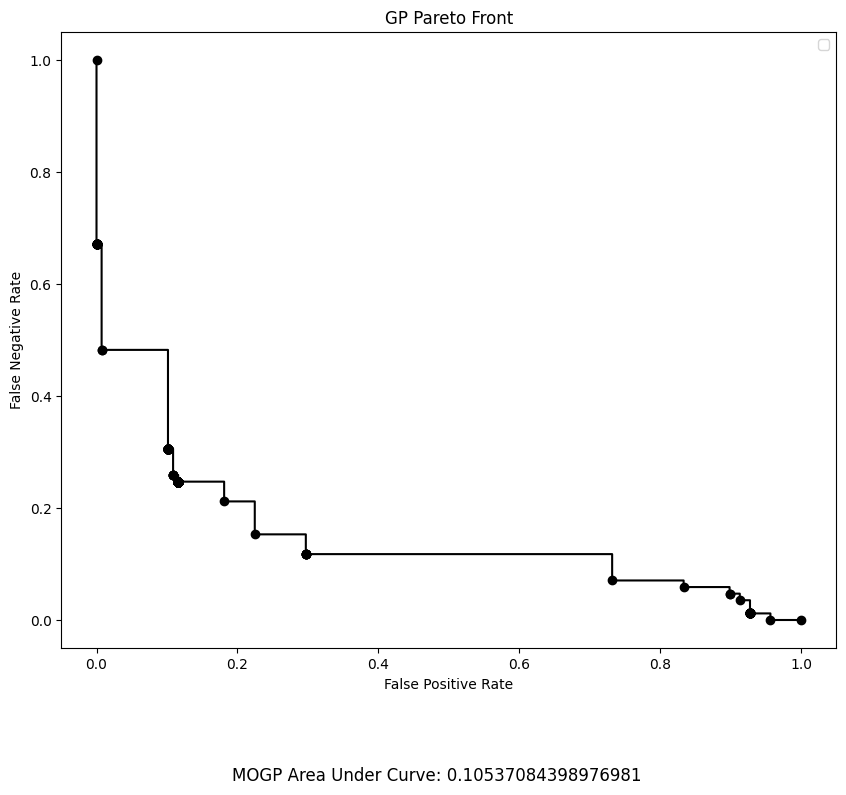

In [ ]:
# Create the plot
fittness_obj1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007246376811594203, 0.007246376811594203, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10144927536231885, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.11594202898550725, 0.18115942028985507, 0.2246376811594203, 0.2971014492753623, 0.2971014492753623, 0.2971014492753623, 0.2971014492753623, 0.2971014492753623, 0.2971014492753623, 0.7318840579710145, 0.8333333333333334, 0.8985507246376812, 0.8985507246376812, 0.9130434782608695, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.927536231884058, 0.9565217391304348, 1]
fittness_obj2 = [1, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.6705882352941176, 0.4823529411764706, 0.4823529411764706, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.3058823529411765, 0.25882352941176473, 0.25882352941176473, 0.25882352941176473, 0.25882352941176473, 0.25882352941176473, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.24705882352941178, 0.21176470588235294, 0.15294117647058825, 0.11764705882352941, 0.11764705882352941, 0.11764705882352941, 0.11764705882352941, 0.11764705882352941, 0.11764705882352941, 0.07058823529411765, 0.058823529411764705, 0.047058823529411764, 0.047058823529411764, 0.03529411764705882, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.0, 0.0]

print( fittness_obj1)
print(fittness_obj2)
plt.figure(figsize=(10, 8))
plt.step(fittness_obj1, fittness_obj2, color='black', where='post')
plt.plot(fittness_obj1, fittness_obj2, 'o', color='black')
area = np.sum(np.abs(np.diff(fittness_obj2)*fittness_obj1[:-1]))

print(area)

# Adding title and labels
plt.title('GP Pareto Front')
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
description_text = 'MOGP Area Under Curve: ' + str(area)
plt.figtext(0.5, -0.05, description_text, ha='center', va='center', fontsize=12)

# Show the legend
plt.legend()

# Display the plot
plt.show()

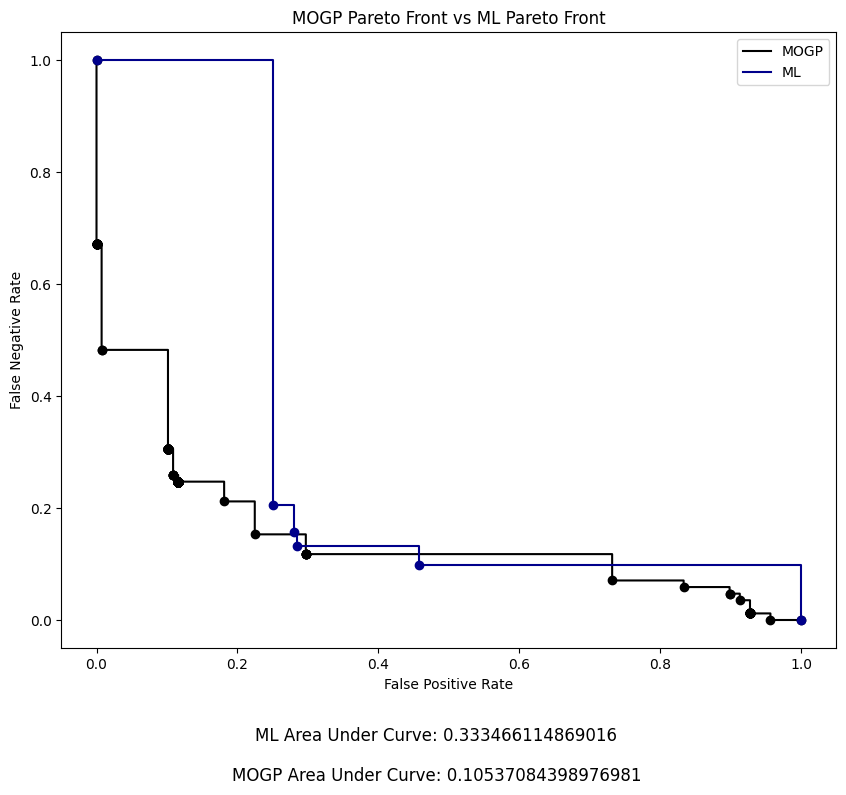

In [ ]:
ML_fpr = [1, 0.45774647887323944, 0.28421052631578947, 0.2808988764044944, 0.25, 0]
ML_fnr = [0, 0.09876543209876543, 0.1328125, 0.15671641791044777, 0.2052980132450331, 1]

# Create the plot
plt.figure(figsize=(10, 8))
plt.step(fittness_obj1, fittness_obj2, color='black', label='MOGP', where='post')
plt.plot(fittness_obj1, fittness_obj2, 'o', color='black')

plt.step(ML_fpr, ML_fnr, color='darkblue', label='ML')
plt.plot(ML_fpr, ML_fnr, 'o', color='darkblue')

area4 = np.sum(np.abs(np.diff(fittness_obj2)*fittness_obj1[:-1]))
area5  = np.sum(np.abs(np.diff(ML_fnr)*ML_fpr[:-1]))

# Adding title and labels
plt.title('MOGP Pareto Front vs ML Pareto Front')
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
description_text = 'MOGP Area Under Curve: ' + str(area4)
description_text2 = 'ML Area Under Curve: ' + str(area5)
plt.figtext(0.5, -0.15, description_text, ha='center', va='center', fontsize=12)
plt.figtext(0.5, -0.2, description_text2, ha='center', va='center', fontsize=12)

# Show the legend
plt.legend()

# Display the plot
plt.show()


[1.0, 0.096, 0.027999999999999997, 0.138, 0.0, 0.048, 0.057999999999999996, 0.11800000000000001, 0.158, 0.11599999999999999, 0.18600000000000003, 0.11599999999999999, 0.012, 0.006, 0.026000000000000002, 0.0, 0.016, 0.14400000000000002, 0.09, 0.152, 0.0]
[0.0, 0.21, 0.588, 0.222, 0.682, 0.5539999999999999, 0.46799999999999997, 0.192, 0.41200000000000003, 0.212, 0.18600000000000003, 0.20800000000000002, 0.654, 0.6659999999999999, 0.622, 0.6759999999999999, 0.6459999999999999, 0.20800000000000002, 0.24600000000000002, 0.182, 1.0]
[(0.0, 0.3), (0.03, 0.59), (0.114, 0.19), (0.138, 0.222), (0.152, 0.2), (0.184, 0.682), (0.18600000000000003, 0.682), (1.0, 0.0)]


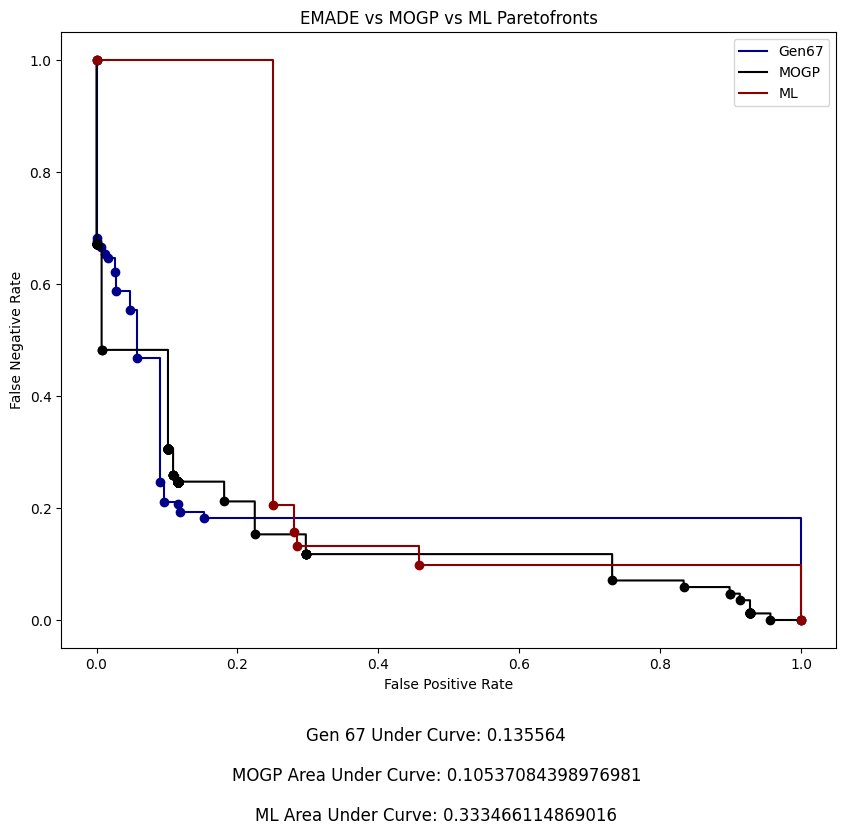

In [ ]:
gen40_fpr = [100,13.8, 18.4, 15.2, 3, 18.6, 11.4, 0]
gen40_fnr = [0, 22.2, 68.2, 20, 59, 68.2, 19, 30, 100]
gen55_fpr = [100, 2.8, 13.8, 11.8, 15.8, 11.6, 18.6, 0, 15.2, 11.4,  0]
gen55_fnr = [0, 58.8, 22.2, 19.2, 41.2, 21.2, 18.6, 68.2, 18.2, 30, 100]
gen67_fpr = [100, 9.6, 2.8, 13.8, 0, 4.8, 5.8, 11.8, 15.8, 11.6, 18.6, 11.6, 1.2, 0.6, 2.6, 0, 1.6, 14.4, 9, 15.2, 0]
gen67_fnr = [0, 21, 58.8, 22.2, 68.2, 55.4, 46.8, 19.2, 41.2, 21.2, 18.6, 20.8, 65.4, 66.6, 62.2, 67.6, 64.6, 20.8, 24.6, 18.2, 100]
gen67_numElements = [36, 52, 33, 46, 85, 60, 39, 32, 35, 33, 58, 52, 76, 69, 67, 60, 36, 55, 56]

for i, num in enumerate(gen67_fpr):
  gen67_fpr[i] = gen67_fpr[i] / 100
  gen67_fnr[i] = gen67_fnr[i] / 100

for i, num in enumerate(gen40_fpr):
  gen40_fpr[i] = gen40_fpr[i] / 100
  gen40_fnr[i] = gen40_fnr[i] / 100


for i, num in enumerate(gen55_fnr):
  gen55_fpr[i] = gen55_fpr[i] / 100
  gen55_fnr[i] = gen55_fnr[i] / 100

print(gen67_fpr)
print(gen67_fnr)

combined = sorted(zip(gen67_fpr, gen67_fnr), key=lambda x: x[0])
combined1 = sorted(zip(gen40_fpr, gen40_fnr), key=lambda x: x[0])
combined2 = sorted(zip(gen55_fpr, gen55_fnr), key=lambda x: x[0])

print(combined1)

# Filter points to identify the Pareto front (non-dominated points)
pareto_front = [combined[0]]
for point in combined[1:]:
    if point[1] <= pareto_front[-1][1]:  # If the current point has a lower (or equal) FNR than the last point on the Pareto front
        pareto_front.append(point)

pareto_front1 = [combined1[0]]
for point in combined1[1:]:
    if point[1] <= pareto_front1[-1][1]:  # If the current point has a lower (or equal) FNR than the last point on the Pareto front
        pareto_front1.append(point)

pareto_front2 = [combined2[0]]
for point in combined2[1:]:
    if point[1] <= pareto_front2[-1][1]:  # If the current point has a lower (or equal) FNR than the last point on the Pareto front
        pareto_front2.append(point)




gen67_fpr = [point[0] for point in pareto_front]
gen67_fnr = [point[1] for point in pareto_front]

gen40_fpr = [point[0] for point in pareto_front1]
gen40_fnr = [point[1] for point in pareto_front1]

gen55_fpr = [point[0] for point in pareto_front2]
gen55_fnr = [point[1] for point in pareto_front2]


gen67_fpr.insert(0, 0)
gen67_fnr.insert(0, 1)
gen40_fnr[0] = 1
gen55_fpr.insert(0, 0)
gen55_fnr.insert(0, 1)

# Create the plot
plt.figure(figsize=(10, 8))

plt.step(gen67_fpr, gen67_fnr, color='darkblue', label='Gen67', where='post')
plt.plot(gen67_fpr, gen67_fnr,'o', color='darkblue')

# plt.step(gen40_fpr, gen40_fnr, color='darkred', label='Gen40', where='post')
# plt.plot(gen40_fpr, gen40_fnr,'o', color='darkred')


# plt.step(gen55_fpr, gen55_fnr, color='darkgreen', label='Gen50', where='post')
# plt.plot(gen55_fpr, gen55_fnr,'o', color='darkgreen')

plt.step(fittness_obj1, fittness_obj2, color='black', label='MOGP', where='post')
plt.plot(fittness_obj1, fittness_obj2, 'o', color='black')

plt.step(ML_fpr, ML_fnr, color='darkred', label='ML')
plt.plot(ML_fpr, ML_fnr, 'o', color='darkred')


area1 = np.trapz(gen40_fnr, gen40_fpr)
area2 = np.trapz(gen55_fnr, gen55_fpr)
area3 = np.trapz(gen67_fnr, gen67_fpr)
area4 = np.sum(np.abs(np.diff(fittness_obj2)*fittness_obj1[:-1]))
area5  = np.sum(np.abs(np.diff(ML_fnr)*ML_fpr[:-1]))

# Adding title and labels
plt.title('EMADE vs MOGP vs ML Paretofronts')
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
description_text = 'Gen 40 Under Curve: ' + str(area1)
description_text2 = 'Gen 55 Under Curve: ' + str(area2)
description_text3 = 'Gen 67 Under Curve: ' + str(area3)
# plt.figtext(0.5, 0, description_text, ha='center', va='center', fontsize=12)
# plt.figtext(0.5, -0.05, description_text2, ha='center', va='center', fontsize=12)
plt.figtext(0.5, 0, description_text3, ha='center', va='center', fontsize=12)
description_text = 'MOGP Area Under Curve: ' + str(area4)
description_text2 = 'ML Area Under Curve: ' + str(area5)
plt.figtext(0.5, -0.05, description_text, ha='center', va='center', fontsize=12)
plt.figtext(0.5, -0.1, description_text2, ha='center', va='center', fontsize=12)

# Show the legend
plt.legend()

# Display the plot
plt.show()

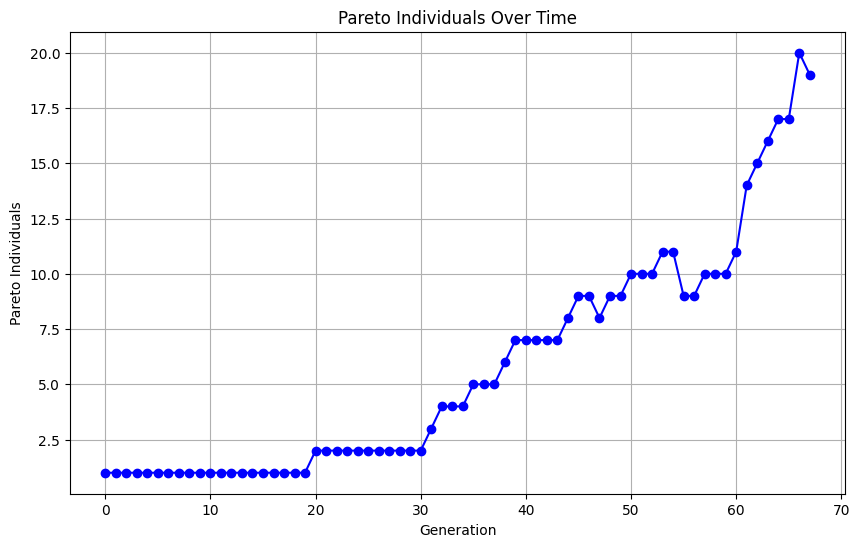

In [ ]:
file_path = '/content/Untitled.csv'
data = pd.read_csv(file_path)

plt.figure(figsize=(10, 6))
plt.plot(data['generation'], data['paretoIndividualsOverTime'], marker='o', linestyle='-', color='b')
plt.title('Pareto Individuals Over Time')
plt.xlabel('Generation')
plt.ylabel('Pareto Individuals')
plt.grid(True)
plt.show()

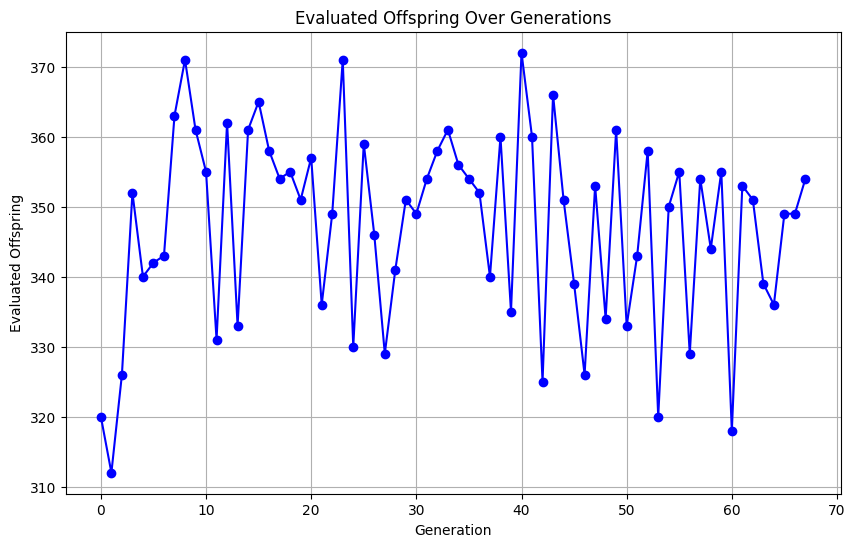

In [ ]:
new_file_path = '/content/evaluatedOffspring.csv'
data = pd.read_csv(new_file_path)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(data['generation'], data['evaluated_offsprin'], marker='o', linestyle='-', color='b')
plt.title('Evaluated Offspring Over Generations')
plt.xlabel('Generation')
plt.ylabel('Evaluated Offspring')
plt.grid(True)
plt.show()